# Multiple trials

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport algebra
%aimport util
%aimport inference
%aimport link
%aimport graph
%precision 4

'%.4f'

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, inference, graph
from algebra import ichol_gauss, subspace

In [3]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
mpl.rcParams['axes.color_cycle'] = ['348ABD', '7A68A6', 'A60628', '467821', 'CF4457', '188487', 'E24A33']
mpl.rcParams['figure.figsize'] = (10, 6)

In [112]:
# dimensions
ntrial = 16
ntime = 1000
nspike = 50
nlatent = 3

## Generate latent

### single trial

Single trial spike trains for testing

In [5]:
np.random.seed(0)
low = np.log(20 / ntime)
aspk = 0.3 + (np.random.random((nlatent, nspike)) - 0.5) * 1.2
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike)))

x = np.empty((1, ntime, nlatent), dtype=float)
x[0, :, 0] = 4 / (1 + np.exp(-np.linspace(-30, 30, num=ntime)))
x[0, :, 1] = 2 * np.sin(0.005 * np.arange(ntime) + 1)
x[0, :, 2] = 2 * np.sin(0.01 * np.arange(ntime) + np.pi)

x[0, :] -= x[0, :].mean(axis=0)

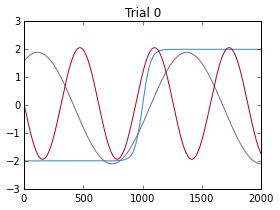

In [6]:
graph.plotdynamics(x, figsize=(4, 3))

In [7]:
y, _, _ = simulation.observation(x, aspk, bspk, dist=stats.poisson.rvs, link=link.sexp)

In [22]:
sample = {'x': x, 'y': y, 'a': aspk, 'b': bspk}
savemat('data/sample', sample)

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


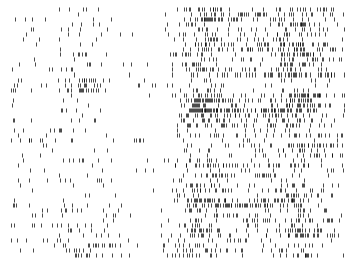

In [9]:
raster_margin = 0.1
figure(figsize=(6, 4.5))
for n in range(nspike):
    vlines(np.arange(ntime)[y[0, :, n] > 0], n + raster_margin, n + 1 - raster_margin, color='black', lw=0.7);
yticks([]);
axis('off')
gca().invert_yaxis();

In [10]:
sigma = np.full(nlatent, fill_value=2.0)
omega = np.array([1e-7, 1e-6, 1e-5])

In [11]:
lb, posterior, param, optim = inference.multitrials(y, None, sigma, omega, lag=3)

Inference starting
Iteration[1], posterior elapsed: 0.53, parameter elapsed: 0.13, total elapsed: 0.90, ELBO: -43082.1175
Iteration[2], posterior elapsed: 0.53, parameter elapsed: 0.14, total elapsed: 0.91, ELBO: -21398.7068
Iteration[3], posterior elapsed: 0.53, parameter elapsed: 0.13, total elapsed: 0.90, ELBO: -14351.8222
Iteration[4], posterior elapsed: 0.54, parameter elapsed: 0.13, total elapsed: 0.92, ELBO: -12371.9036
Iteration[5], posterior elapsed: 0.53, parameter elapsed: 0.13, total elapsed: 0.91, ELBO: -11845.1634
Iteration[6], posterior elapsed: 0.53, parameter elapsed: 0.14, total elapsed: 0.90, ELBO: -11684.3266
Iteration[7], posterior elapsed: 0.53, parameter elapsed: 0.14, total elapsed: 0.90, ELBO: -11584.3722
Iteration[8], posterior elapsed: 0.54, parameter elapsed: 0.14, total elapsed: 0.92, ELBO: -11385.7778
Iteration[9], posterior elapsed: 0.56, parameter elapsed: 0.14, total elapsed: 0.95, ELBO: -11306.9241
Iteration[10], posterior elapsed: 0.60, parameter elap

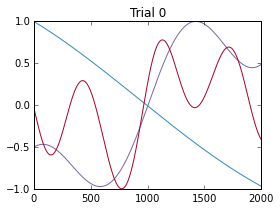

In [14]:
graph.plotdynamics(posterior['mu'], figsize=(4, 3))

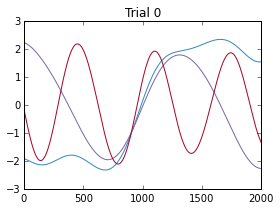

In [15]:
rotated = np.empty_like(posterior['mu'])
for m in range(1):
    rotated[m, :] = util.rotate(posterior['mu'][m, :], x[m, :])
graph.plotdynamics(rotated, figsize=(4, 3))

In [28]:
algebra.subspace(aspk.T, param['a'].T) * 180 / np.pi

28.3887

In [29]:
algebra.subspace(x, posterior['mu'][0, :]) / np.pi * 180

88.8343

### Lorenz attractor

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


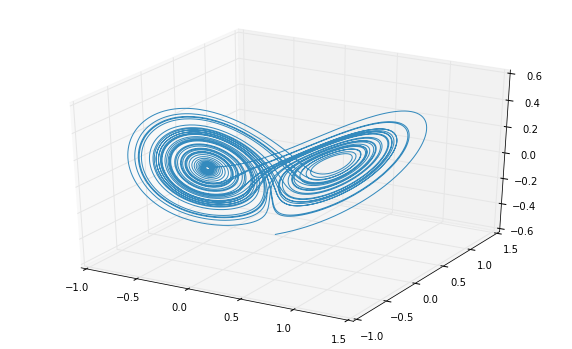

In [113]:
lorenz = simulation.lorenz(ntime * ntrial, dt=3e-3, x0=np.random.random(3))
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(lorenz[:, 0], lorenz[:, 1], lorenz[:, 2]);

In [114]:
x = lorenz.reshape((ntrial, ntime, -1))
for m in range(ntrial):
    x[m, :] = (x[m, :] - x[m, :].mean(axis=0)) / norm(x[m, :], axis=0, ord=np.inf)

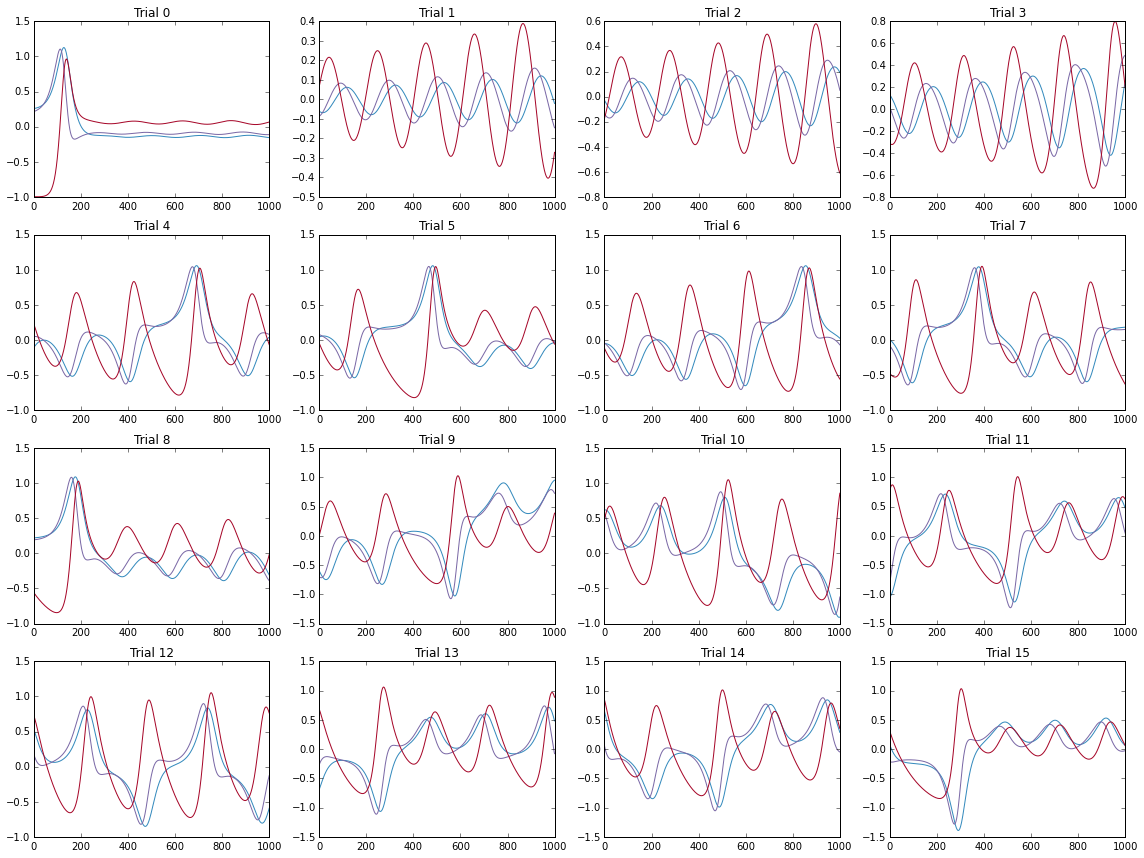

In [115]:
graph.dynplot(x, figsize=(4, 3))

Simulate spike trains

In [116]:
np.random.seed(0)
low = np.log(20 / ntime)
aspk = 0.3 + (np.random.random((nlatent, nspike)) - 0.5) * 1.2
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike)))

In [117]:
y, _, _ = simulation.spike(x, aspk, bspk)

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


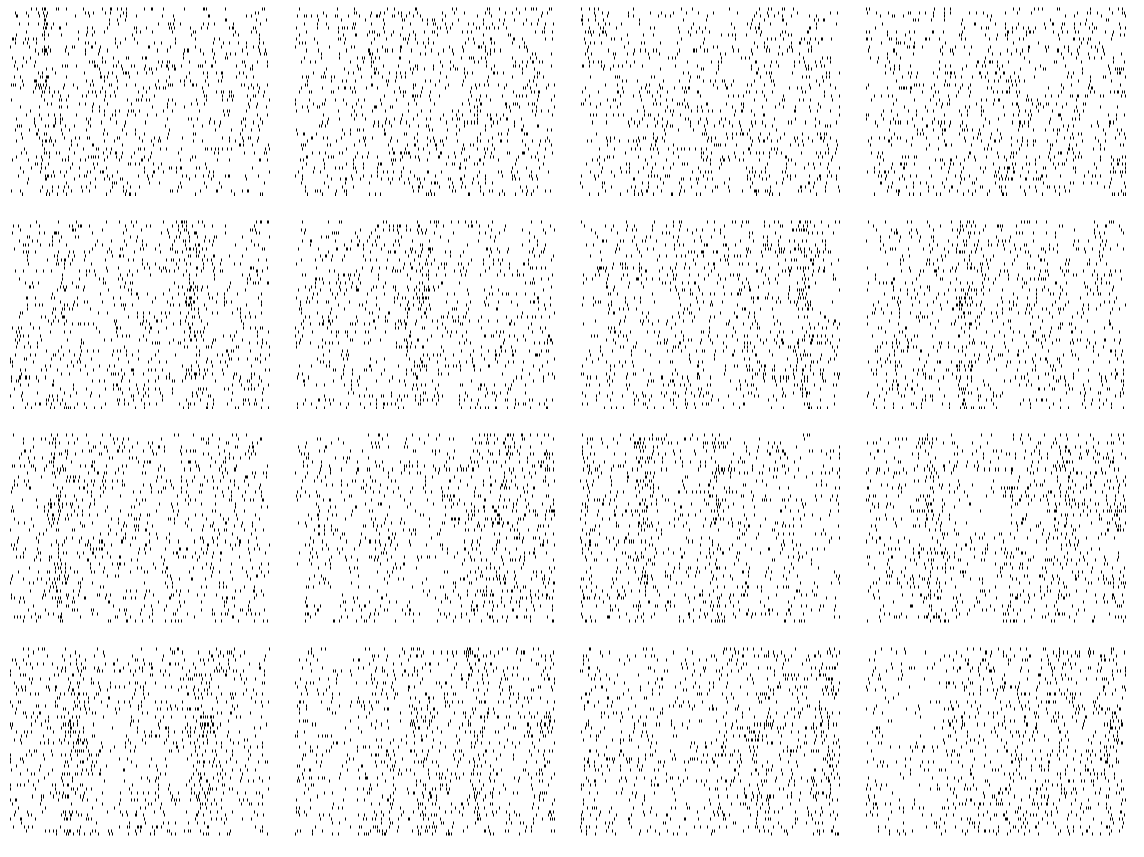

In [118]:
graph.rasterplot(y, ncol=4, figsize=(4, 3));

In [132]:
sample_lorenz1 = {'y': y, 'x': x, 'a': aspk, 'b':bspk}
savemat('data/sample_lorenz1', sample_lorenz1)

In [119]:
sigma = np.full(nlatent, fill_value=1.0)
omega = np.full(nlatent, fill_value=1e-3)

In [133]:
result = inference.multitrials(y[:15, :, :], None, sigma, omega, x=x[:15, :, :], ta=aspk, tb=bspk, lag=0)

Inference starting
Iteration[1], posterior elapsed: 7.19, parameter elapsed: 1.38, total elapsed: 11.84, ELBO: -323547.6606
Iteration[2], posterior elapsed: 6.46, parameter elapsed: 1.36, total elapsed: 11.10, ELBO: -161515.4913
Iteration[3], posterior elapsed: 6.50, parameter elapsed: 1.41, total elapsed: 11.22, ELBO: -109856.1012
Iteration[4], posterior elapsed: 6.50, parameter elapsed: 1.39, total elapsed: 11.29, ELBO: -96675.2627
Iteration[5], posterior elapsed: 6.56, parameter elapsed: 1.39, total elapsed: 11.24, ELBO: -94665.0396
Iteration[6], posterior elapsed: 6.69, parameter elapsed: 1.36, total elapsed: 11.36, ELBO: -94527.6945
Iteration[7], posterior elapsed: 6.50, parameter elapsed: 1.35, total elapsed: 11.13, ELBO: -94513.1102
Iteration[8], posterior elapsed: 6.52, parameter elapsed: 1.39, total elapsed: 11.19, ELBO: -94507.2245
Iteration[9], posterior elapsed: 6.53, parameter elapsed: 1.36, total elapsed: 11.25, ELBO: -94504.0713
Iteration[10], posterior elapsed: 6.51, pa

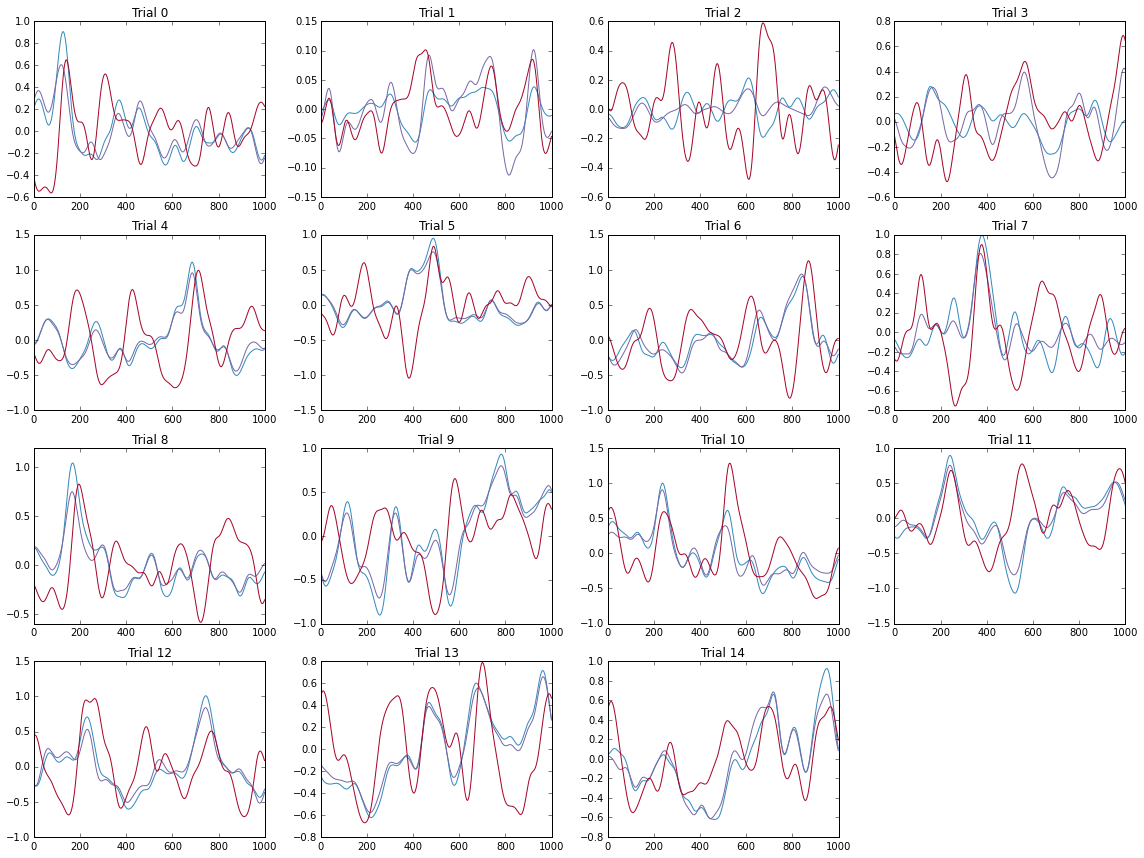

In [138]:
rotated = np.empty_like(result['posterior']['mu'])
for m in range(ntrial - 1):
    rotated[m, :] = util.rotate(result['posterior']['mu'][m, :], x[m, :])
graph.dynplot(rotated, figsize=(4, 3))

In [125]:
result['stat']

{'ELBO': array([-34879294.8856,   -323547.6606,   -161515.4913,   -109856.1012,
           -96675.2627,    -94665.0396,    -94527.6945,    -94513.1102,
           -94507.2245,    -94504.0713,    -94502.446 ,    -94501.5307]),
 'elapsed': array([[  0.0000e+000,   0.0000e+000,   7.7486e-304],
        [  6.4470e+000,   1.3967e+000,   1.1159e+001],
        [  6.4912e+000,   1.3737e+000,   1.1181e+001],
        [  6.5428e+000,   1.3751e+000,   1.1152e+001],
        [  6.9964e+000,   1.3739e+000,   1.1782e+001],
        [  7.2322e+000,   1.3920e+000,   1.2014e+001],
        [  6.6273e+000,   1.4078e+000,   1.1442e+001],
        [  6.5911e+000,   1.3405e+000,   1.1270e+001],
        [  6.5755e+000,   1.4164e+000,   1.1341e+001],
        [  6.5031e+000,   1.3616e+000,   1.1167e+001],
        [  6.5909e+000,   1.3789e+000,   1.1243e+001],
        [  6.5037e+000,   1.3659e+000,   1.1180e+001]]),
 'latentangle': array([ 0.    ,  1.5154,  1.5224,  1.5192,  1.5197,  1.503 ,  1.5072,
         1.5379

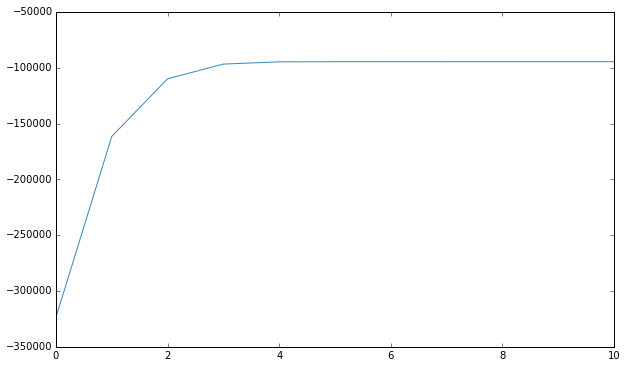

In [135]:
plot(result['stat']['ELBO'][1:]);

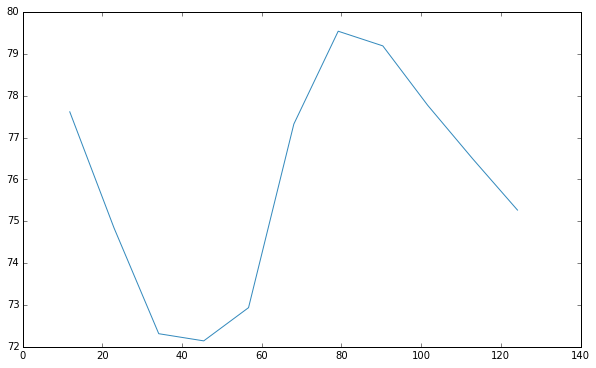

In [143]:
plot(np.cumsum(result['stat']['elapsed'][1:,2]), result['stat']['loadingangle'][1:] * 180 / np.pi);

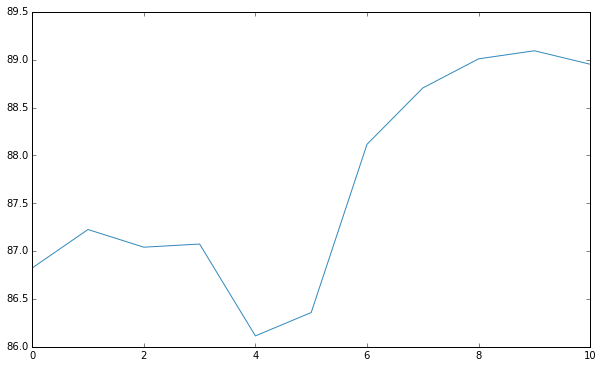

In [137]:
plot(result['stat']['latentangle'][1:] * 180 / np.pi);

In [140]:
result['stat']['elapsed'][:,2]

array([-574.564 ,   11.8415,   11.1034,   11.2208,   11.2873,   11.2409,
         11.3649,   11.129 ,   11.1931,   11.2513,   11.3566,   11.1827])